In [1]:
import math
import numpy as np
import time
import pandas as pd
import pyopencl as cl
import matplotlib.pyplot as plt
from string import Template
def primes(n):
    x = np.ones((n+1,), dtype=bool)
    x[0] = False
    x[1] = False
    x[4::2] = False
    for i in range(3, int(n**0.5)+1):
        if x[i]:
            x[i*i::2*i] = False
    primes = np.where(x == True)[0]
    return primes

def primes5M8(n,pList): #pList shouldn't include 2
    x = np.ones(((n-5)//8+1,), dtype=bool)
    for i in pList:
        #x[int((i+5)*(i-1)/8)::i] = False
        x[int(i*(i+4)/8)::i] = False
    return x

def squarefree5M8(n,pList): #pList shouldn't include 2
    x = np.ones(((n-5)//8+1,), dtype=bool)
    for i in pList:
        k=i*i
        x[int((5*k-5)/8)::k] = False
    return 5,x

def squarefree5M8Partial(a,b,pList): #pList shouldn't include 2, and a should be 5 mod 8
    A = int((a-5)/8)
    #B = int((b-5)/8)
    x = np.ones((b-a)//8+1, dtype=bool)
    for p in pList:
        k=p*p
        t = math.ceil((a/k-5)/8)
        #nextMultipleIndex = ((t*8+5)*k-a)//8
        testNMI = t*k - A + math.floor(5*(k-1)/8)
        #print(nextMultipleIndex,testNMI)
        x[testNMI::k] = False
    return a,x
        
def squarefreeFull(n):
    return getBlock(squarefree5M8(n,primes(int(n**0.5)+1)[1:]))

def primesFull(n):
    return getBlock(primes5M8(n,primes(int(n**0.5)+1)[1:]))

def getBlock(min,x,all=True,blockSize=0,blockID=0):
    if all:
        return (np.where(x==True)[0])*8+min
    l = len(x)
    start = blockSize * blockID
    end = start + blockSize
    if start >= l:
        return -1
    if end >= l:
        xpart = x[start:]
    else:
        xpart = x[start:end]
    return (np.where(xpart==True)[0]+start)*8+min

In [14]:
def unitsGPU(array,options):
    count = len(array)
    print(count, "values from", array[0], "to", array[-1])
    result = np.zeros(count,dtype=np.int32)
    bstep = np.zeros(count,dtype=np.int32)
    gstep = np.zeros(count,dtype=np.int32)
    
    context = cl.create_some_context()
    queue = cl.CommandQueue(context,properties=cl.command_queue_properties.PROFILING_ENABLE)
    with open("bsgs5mod8GPU_sort_NUCOMP_vdP_Bloom.c","r") as file:
        program_src = Template(file.read()).substitute(options)
    program = cl.Program(context, program_src).build()
    
    array_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=array)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=result)
    bstep_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=bstep)
    gstep_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=gstep)
    
    kernel = program.sum_array
    kernel.set_arg(0, array_buf)
    kernel.set_arg(1, result_buf)
    kernel.set_arg(2, bstep_buf)
    kernel.set_arg(3, gstep_buf)
    global_size = (count,)
    
    t1 = time.time()
    cl.enqueue_nd_range_kernel(queue, kernel, global_size, None)
    cl.enqueue_copy(queue, result, result_buf)
    cl.enqueue_copy(queue, bstep, bstep_buf)
    cl.enqueue_copy(queue, gstep, gstep_buf)
    queue.finish()
    t2 = time.time()

    print("Finished in", t2-t1, "seconds.")
    
    del array_buf
    del result_buf
    del kernel
    del program
    del queue
    del context
    return result,bstep,gstep


In [3]:
maximum = (10**11)
sieveBlockSize = 2*(10**9)

In [ ]:
for i in range(0,50):
    t1 = time.time()
    min,A = squarefree5M8Partial(5+i*sieveBlockSize,-3+(i+1)*sieveBlockSize,primes(int((-3+(i+1)*sieveBlockSize)**0.5)+1)[1:])
    np.save("squarefree numbers\\"+str(min)+".npy",A)
    t2 = time.time()
    print("Sieved in", t2-t1, "seconds")

Sieved in 7.699926853179932 seconds
Sieved in 3.812703847885132 seconds
Sieved in 4.770315408706665 seconds
Sieved in 5.0091471672058105 seconds
Sieved in 4.637627363204956 seconds
Sieved in 5.28813099861145 seconds
Sieved in 5.73832368850708 seconds
Sieved in 4.216253042221069 seconds
Sieved in 3.483208417892456 seconds
Sieved in 2.3445358276367188 seconds
Sieved in 2.8185172080993652 seconds
Sieved in 3.9571502208709717 seconds
Sieved in 4.285348653793335 seconds
Sieved in 4.414165258407593 seconds
Sieved in 9.810021877288818 seconds
Sieved in 7.296102046966553 seconds
Sieved in 5.755092620849609 seconds
Sieved in 5.616697788238525 seconds
Sieved in 5.089153289794922 seconds
Sieved in 4.397475242614746 seconds
Sieved in 3.65501070022583 seconds
Sieved in 3.449648857116699 seconds
Sieved in 4.159335613250732 seconds
Sieved in 4.786479234695435 seconds
Sieved in 5.113647937774658 seconds
Sieved in 5.151026010513306 seconds
Sieved in 5.46660304069519 seconds
Sieved in 5.516543626785278 

In [5]:
options = {"mainDictSize":700,"giantStepMax":10000,"BLOOM_SIZE":8192,"NUM_HASHES":3}

In [ ]:
for k in range(0,100,2):
    t1 = time.time()
    counts = np.array([0,0,0])
    blockSize=10**6


    list0=[]
    list1=[]
    list2=[]
    outputBlockSize = 10**5
    ratio = blockSize//outputBlockSize
    m = k*10**9+5
    A = np.load("squarefree numbers\\"+str(m)+".npy")
    for i in range(0,math.ceil(sieveBlockSize/blockSize)):
        array = getBlock(m,A,False,blockSize//8,i)
        #array = np.array([94000000013])
        r,bstep,gstep=unitsGPU(array,options)
        if (i==0 and k==0):
            r[0] = 1
        errorPlace = r<0
        print("Errors at",array[errorPlace])
        print("Error codes are",r[errorPlace])
        #print("Results are",r)
        #print("Max baby steps needed:",max(bstep))
        #print("Average giant steps needed:",gstep.mean())
        print()
        c=np.unique(r,return_counts=True)[1][-3:]
        list0 += list(np.bincount(array[r==0]//(outputBlockSize))[-ratio:])
        list1 += list(np.bincount(array[r==1]//(outputBlockSize))[-ratio:])
        list2 += list(np.bincount(array[r==2]//(outputBlockSize))[-ratio:])
        #print("Counts are:",c)
        counts += c
    t2 = time.time()
    print("Final counts are",counts)
    print("Total time:", t2-t1)
    df=pd.DataFrame([list0,list1,list2]).transpose()
    index = (df.index+1)*outputBlockSize
    df.index=index
    df.to_csv(str(k)+"_data.csv")

101322 values from 5 to 999997


c:\Users\james\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


Finished in 0.511223554611206 seconds.
Errors at []
Error codes are []

101323 values from 1000005 to 1999997
Finished in 0.4315056800842285 seconds.
Errors at []
Error codes are []

101314 values from 2000005 to 2999989
Finished in 0.4490664005279541 seconds.
Errors at []
Error codes are []

Final counts are [ 94641 104747 104571]
Total time: 2.8845202922821045
101298 values from 70000000005 to 70000999997


c:\Users\james\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


Finished in 4.326035022735596 seconds.
Errors at []
Error codes are []

101318 values from 70001000005 to 70001999997
Finished in 3.9508216381073 seconds.
Errors at []
Error codes are []

101328 values from 70002000013 to 70002999989
Finished in 3.6682498455047607 seconds.
Errors at []
Error codes are []

Final counts are [100621 101639 101684]
Total time: 12.666475534439087


In [10]:
#list0=np.cumsum(list0)
#list1=np.cumsum(list1)
#list2=np.cumsum(list2)
#realPart=list0-1/2*(list1+list2)
#imagPart=math.sqrt(3)/2*(list1-list2)
#t=list0+list1+list2
#s=list1+list2
#r=s/list0

#df=pd.DataFrame([list0,list1,list2,realPart,imagPart,t,s,r]).transpose()
df=pd.DataFrame([list0,list1,list2]).transpose()
index = (df.index+1)*outputBlockSize
df.index=index
df.to_csv("testData.csv")

In [ ]:
answers = []
t1 = time.time()
for i in array:
    try:
        Ff = reduceQP(i)
        answers.append(Ff)
    except:
        print(i,"Failed")
t2 = time.time()
print(t2-t1)

0.013852357864379883


In [10]:
def getLists(r, part):
    if part == "I":
        return [r==0,r==1,r==2],[0,math.sqrt(3)/2,-math.sqrt(3)/2]
    elif part == "R":
        return [r==0,True],[1,-1/2]
def select(r, part):
    l1, l2 = getLists(r, part)
    return np.select(l1,l2,-999)

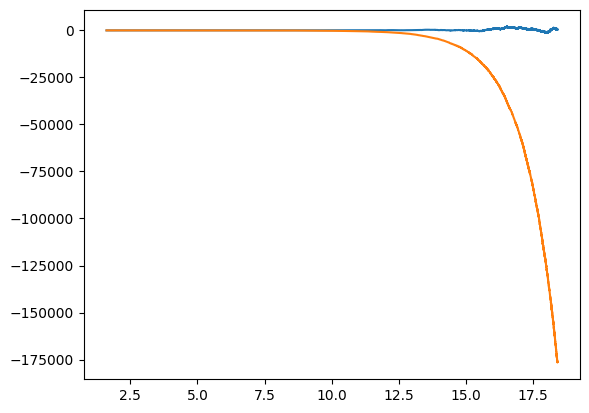

In [100]:
plt.plot(np.log(array[0::100]),np.cumsum(select(randomArray,"R"))[0::100])
plt.plot(np.log(array[0::100]),np.cumsum(select(r,"R"))[0::100])
#plt.plot(array[0::100],bestFitArray[0::100])

In [101]:
bestFitArray=-3/(8*(np.pi**2))*np.power(array,5/6)

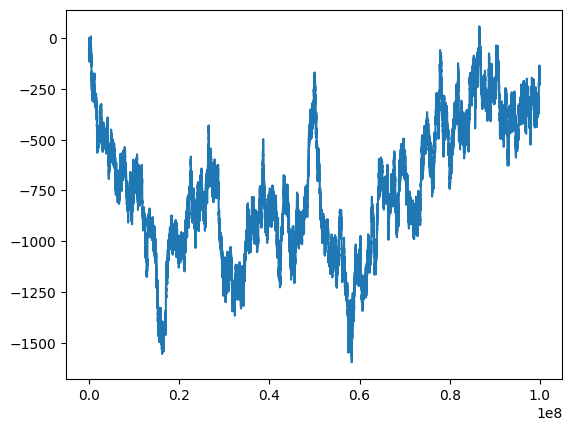

In [104]:
plt.plot(array[0::100],np.cumsum(select(r,"R"))[0::100]-bestFitArray[0::100])

In [78]:
c

array([3259668, 3437623, 3434823], dtype=int64)

In [89]:
def estC(n):
    return n/(np.pi)**2-1/(12*(np.pi)**2)*(4*n-3*(n**(5/6)))

In [99]:
estC(10**9)

68348470.05039348

In [74]:
np.cumsum(select(r,"R"))

array([-5.000000e-01, -1.000000e+00, -1.500000e+00, ..., -1.765555e+05,
       -1.765545e+05, -1.765550e+05])

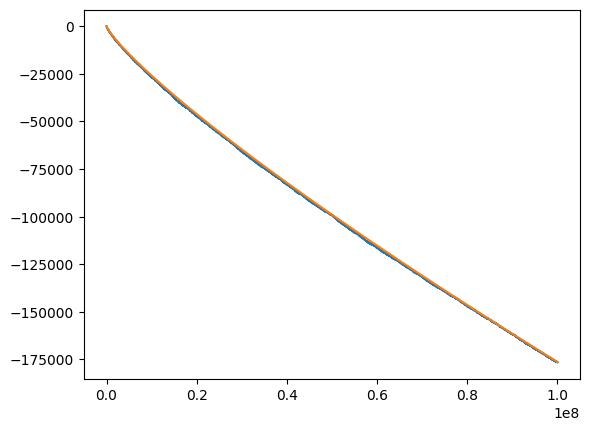

In [77]:
plt.plot(array[0::100],np.cumsum(select(r,"R"))[0::100])
plt.plot(array[0::100],bestFitArray[0::100])

In [23]:
rootArray=array.copy()
rootResult = r.copy()
newArray = np.array([],dtype="int32")
newResult = np.array([],dtype="int32")
newBase = np.array([],dtype="int32")
n = 2
while True:
    lessRoot = rootArray<maximum**(1/n)
    rootResult = rootResult[lessRoot]
    if len(rootResult)==0:
        break
    rootArray = rootArray[lessRoot]
    powerRootArray = rootArray**n
    powerRootResult = (rootResult*n)%3
    newArray = np.concatenate((newArray,powerRootArray))
    newResult = np.concatenate((newResult,powerRootResult))
    newBase = np.concatenate((newBase,rootArray))
    n = n + 1
newResult = np.concatenate((np.log(array)*select(r,"R"),np.log(newBase)*select(newResult,"R")))
newArray = np.concatenate((array,newArray))
argSortArray = np.argsort(newArray)
newArray = newArray[argSortArray]
newResult = newResult[argSortArray]
psiArray = np.cumsum(newResult)

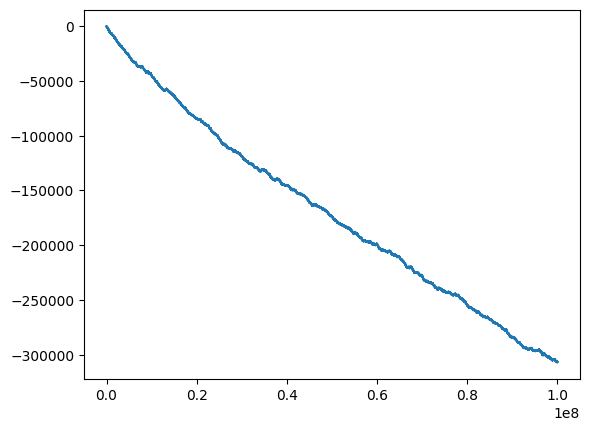

In [24]:
plt.plot(newArray[0::10],psiArray[0::10])
#plt.plot(array[0::1000],bestFitArray[0::1000])

In [ ]:
def sieve(upperLimit, primes):
    r = np.array(list(range(2,upperLimit+1)),dtype=np.int64)
    for p in primes:
        r[2*p-2:upperLimit-1:p]=0
    return r[r!=0]

def GPUsieve(upperLimit, primes, context, queue, program):
    result = np.array(list(range(2,upperLimit+1)),dtype=np.int64)
    count = len(primes)
    array_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=primes)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=result)
    kernel = program.sum_array
    kernel.set_arg(0, array_buf)
    kernel.set_arg(1, result_buf)
    kernel.set_arg(2, np.int64(upperLimit))
    global_size = (count,)
    cl.enqueue_nd_range_kernel(queue, kernel, global_size, None)
    cl.enqueue_copy(queue, result, result_buf)
    queue.finish()
    
    return result[result!=0]


def fullGPUSieve(upperLimit,context,queue,program):
    if upperLimit < 10:
        return np.array([i for i in range(2,upperLimit+1) if prime(i)],dtype=np.int64)
    else:
        return GPUsieve(upperLimit,fullSieve(math.floor(math.sqrt(upperLimit))),context,queue,program)

def GPUstartArray(n):
    context = cl.create_some_context()
    queue = cl.CommandQueue(context)
    with open("sieve.c","r") as file:
        program_src = file.read()
    program = cl.Program(context, program_src).build()
    return pick5M8(fullGPUSieve(n,context,queue,program))[1:]

def squarefree(n):
    for i in range(2,math.ceil(math.sqrt(n))+1):
        if n%(i**2)==0:
            return False
    return True

def prime(n):
    if n==1:
        return False
    for i in range(2,math.floor(math.sqrt(n))+1):
        if n%i==0:
            return False
    return True

def fullSieve(upperLimit):
    if upperLimit < 10:
        return np.array([i for i in range(2,upperLimit+1) if prime(i)],dtype=np.int64)
    else:
        return sieve(upperLimit,fullSieve(math.floor(math.sqrt(upperLimit))))

def pick5M8(array):
    return array[(array%8)==5]

def startArray(n):
    return pick5M8(fullSieve(n))[1:]


'''start = 13
end = 2**20
t1 = time.time()
array = startArray(end)
print(len(array))
t2 = time.time()
t2 - t1'''